# Set Up

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# change to your working directory
#%cd "/content/drive/MyDrive/shared folder/Master_Thesis"
%cd "/content/drive/MyDrive/shared_folder/Master_Thesis" 

/content/drive/.shortcut-targets-by-id/1lHcON5EHJDerZlJ2mPUGsY4w6iFLBKs5/shared_folder/Master_Thesis


In [ ]:
!pip install adapt

In [ ]:
import os, random, shutil, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from PIL import Image

from sklearn.preprocessing import OneHotEncoder
from sklearn.manifold import TSNE

import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad
from tensorflow.keras.layers import Dense, Input, Dropout, Conv2D, MaxPooling2D, Flatten, Reshape, GaussianNoise 
from tensorflow.keras.layers import BatchNormalization,  GlobalMaxPooling2D, GlobalAveragePooling2D,  Add
from tensorflow.keras.applications import VGG16, InceptionV3, ResNet50, ResNet50V2, MobileNetV3Large
from tensorflow.keras.constraints import MinMaxNorm, MaxNorm
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50
from tensorflow.keras.models import Model, load_model
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.optimizers.schedules import LearningRateSchedule

from adapt.parameter_based import FineTuning
from adapt.feature_based import MDD
from adapt.utils import UpdateLambda

In [ ]:
print("GPU Available: ", tf.test.is_gpu_available())
print(tf.__version__)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Available:  True
2.8.0


In [ ]:
# Original Dataset
Source_dir_train1 = "./Images/DANN/Source/LC25000_mix_data_256_3200_train1.pkl"
Source_dir_train2 = "./Images/DANN/Source/LC25000_mix_data_256_3200_train2.pkl"
Source_dir_train3 = "./Images/DANN/Source/LC25000_mix_data_256_3200_train3.pkl"


Target_dir_train1 = os.path.abspath("./Images/DANN/Target/TCGA_mix_data_256_3200_train1.pkl")
Target_dir_train2 = os.path.abspath("./Images/DANN/Target/TCGA_mix_data_256_3200_train2.pkl")
Target_dir_test1 = os.path.abspath("./Images/DANN/Target/TCGA_mix_data_256_3200_test1.pkl")
Target_dir_test2 = os.path.abspath("./Images/DANN/Target/TCGA_mix_data_256_3200_test2.pkl")

# Cyclegan Dataset

Target_cyclegan_dir_train1 = os.path.abspath("./Images/DANN/Target_cyclegan/TCGA_cyclegan_mix_data_256_3200_train1.pkl")
Target_cyclegan_dir_train2 = os.path.abspath("./Images/DANN/Target_cyclegan/TCGA_cyclegan_mix_data_256_3200_train2.pkl")
Target_cyclegan_dir_test1 = os.path.abspath("./Images/DANN/Target_cyclegan/TCGA_cyclegan_mix_data_256_3200_test1.pkl")
Target_cyclegan_dir_test2 = os.path.abspath("./Images/DANN/Target_cyclegan/TCGA_cyclegan_mix_data_256_3200_test2.pkl")

In [ ]:
BATCH_SIZE = 16
CHANNELS = 3
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256

# Loading Dataset

## LC25000 Dataset

In [ ]:
# LC25000 Dataset
with open(os.path.abspath(Source_dir_train1), "rb") as f:
    LC25000_train1 = pickle.load(f)
with open(os.path.abspath(Source_dir_train2), "rb") as f:
    LC25000_train2 = pickle.load(f)
with open(os.path.abspath(Source_dir_train3), "rb") as f:
    LC25000_train3 = pickle.load(f)

In [ ]:
LC25000_train_data = LC25000_train1['train'] + LC25000_train2['train'] + LC25000_train3['train'] 
LC25000_train_labels = np.concatenate((LC25000_train1['train_label'],LC25000_train2['train_label'],LC25000_train3['train_label']))


In [ ]:
LC25000_train_lab = tf.one_hot(LC25000_train_labels, depth=3)

In [ ]:
LC25000_train_data = np.array(LC25000_train_data, dtype=np.float32)

In [ ]:
print("The shape of LC25000_train_data: ", np.shape(LC25000_train_data))
print("The shape of LC25000_train_labels: ", np.shape(LC25000_train_labels))

The shape of LC25000_train_data:  (3200, 256, 256, 3)
The shape of LC25000_train_labels:  (3200,)


In [ ]:
import gc
gc.collect()

272

## TCGA Dataset

In [ ]:
# TCGA Dataset
with open(os.path.abspath(Target_dir_train1), "rb") as f:
    TCGA_train1 = pickle.load(f)
with open(os.path.abspath(Target_dir_test1), "rb") as f:
    TCGA_test1 = pickle.load(f)
with open(os.path.abspath(Target_dir_train2), "rb") as f:
    TCGA_train2 = pickle.load(f)
with open(os.path.abspath(Target_dir_test2), "rb") as f:
    TCGA_test2 = pickle.load(f)

In [ ]:
TCGA_train_data = TCGA_train1['train'] + TCGA_train2['train']
TCGA_train_labels = np.concatenate((TCGA_train1['train_label'],TCGA_train2['train_label']))
TCGA_test_data = TCGA_test1['test'] + TCGA_test2['test']
TCGA_test_labels = np.concatenate((TCGA_test1['test_label'],TCGA_test2['test_label']))

In [ ]:
TCGA_train_lab = tf.one_hot(TCGA_train_labels, depth=3)
TCGA_test_lab = tf.one_hot(TCGA_test_labels, depth=3)

In [ ]:
TCGA_train_data = np.array(TCGA_train_data, dtype=np.float32)
TCGA_test_data = np.array(TCGA_test_data, dtype=np.float32)

In [ ]:
print("The shape of TCGA_train_data: ", np.shape(TCGA_train_data))
print("The shape of TCGA_train_labels: ", np.shape(TCGA_train_labels))
print("The shape of TCGA_test_data: ", np.shape(TCGA_test_data))
print("The shape of TCGA_test_labels: " , np.shape(TCGA_test_labels))

The shape of TCGA_train_data:  (3200, 256, 256, 3)
The shape of TCGA_train_labels:  (3200,)
The shape of TCGA_test_data:  (3200, 256, 256, 3)
The shape of TCGA_test_labels:  (3200,)


./Images/TCGA_patch/patch/patch_train  contains  3200  scc and  3200  aca.

./Images/TCGA_patch/patch/patch_test  contains  3200  scc and  3200  aca.

./Images/TCGA_patch/patch_cyclegan/patch_cyclegan_train  contains  3200  scc and  3200  aca.

./Images/TCGA_patch/patch_cyclegan/patch_cyclegan_test  contains  3200  scc and  3200  aca.

In [ ]:
import gc
gc.collect()

253

## Datasets Visualization

<function matplotlib.pyplot.show>

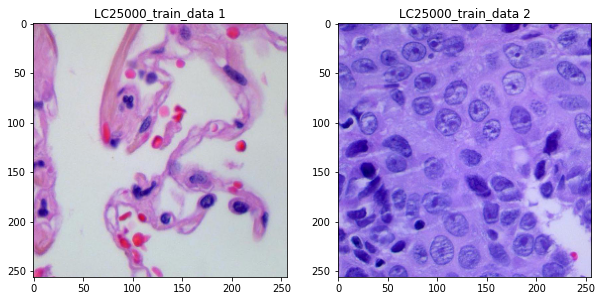

In [ ]:
# random show source images
fig = plt.subplots(1,2,figsize=(10,10))
#plt.suptitle("Source Domain = LC25000", fontsize=18)
ax1=plt.subplot(1,2,1)
sample1 = random.choice(LC25000_train_data)
img1 = array_to_img(sample1)
plt.show
plt.title("LC25000_train_data 1")
plt.imshow(img1)
ax1=plt.subplot(1,2,2)
sample2 = random.choice(LC25000_train_data)
img2 = array_to_img(sample2)
plt.title("LC25000_train_data 2")
plt.imshow(img2)
plt.show

<function matplotlib.pyplot.show>

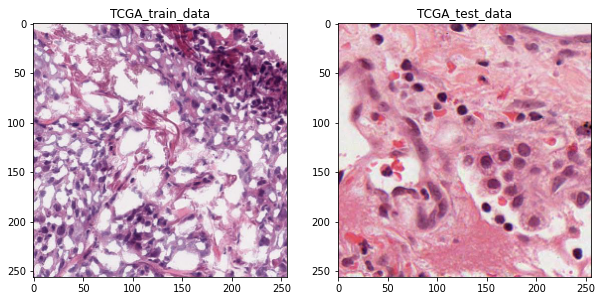

In [ ]:
# random show Target images
plt.subplots(1,2,figsize=(10,10))
ax1=plt.subplot(1,2,1)
sample1 = random.choice(TCGA_train_data)
img1 = array_to_img(sample1)
plt.title("TCGA_train_data")
plt.imshow(img1)
ax1=plt.subplot(1,2,2)
sample2 = random.choice(TCGA_test_data)
img2 = array_to_img(sample2)
plt.title("TCGA_test_data")
plt.imshow(img2)
plt.show

# Domain Adaptation

## Build Model

### Feature Extractor - ResNet50V2

In [ ]:
resnet50 = ResNet50(include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS), pooling="avg")

first_layer = resnet50.get_layer('conv5_block2_out')
inputs = Input(first_layer.output_shape[1:])

for layer in resnet50.layers[resnet50.layers.index(first_layer)+1:]:
    if layer.name == "conv5_block3_1_conv":
        x = layer(inputs)
    elif layer.name == "conv5_block3_add":  # change name
        x = layer([inputs, x])
    else:
        if layer.name == "conv5_block3_preact_bn":
            pass
        else:
            x = layer(x)

first_blocks = Model(resnet50.input, first_layer.output)
last_block = Model(inputs, x)

In [ ]:
def load_resnet50(path="./Model/DANN_Model/resnet50_last_block_256.hdf5"):
    model = load_model(path)
    for i in range(len(model.layers)):
        if model.layers[i].__class__.__name__ == "BatchNormalization":
            model.layers[i].trainable = False
    return model

last_block.summary()
last_block.save("./Model/DANN_Model/resnet50_last_block_256.hdf5")

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 8, 8, 2048)  0           []                               
                                ]                                                                 
                                                                                                  
 conv5_block3_1_conv (Conv2D)   (None, 8, 8, 512)    1049088     ['input_2[0][0]']                
                                                                                                  
 conv5_block3_1_bn (BatchNormal  (None, 8, 8, 512)   2048        ['conv5_block3_1_conv[1][0]']    
 ization)                                                                                         
                                                                                            

### Extract the features 

In [ ]:
LC25000_train_data_ex = first_blocks.predict(preprocess_input(np.stack(LC25000_train_data)))
TCGA_train_data_ex = first_blocks.predict(preprocess_input(np.stack(TCGA_train_data)))

print("LC25000_train_data (source) shape: %s"%str(LC25000_train_data.shape))
print("TCGA_train_data (target) shape: %s"%str(TCGA_train_data.shape))

LC25000_train_data (source) shape: (3200, 256, 256, 3)
TCGA_train_data (target) shape: (3200, 256, 256, 3)


### Label Predictor

In [ ]:
def get_task(dropout=0.5, max_norm=0.5):
    model = Sequential()
    model.add(Dense(1024, activation="relu",
                   kernel_constraint=MaxNorm(max_norm),
                   bias_constraint=MaxNorm(max_norm)))
    model.add(Dropout(dropout))
    model.add(Dense(1024, activation="relu",
                   kernel_constraint=MaxNorm(max_norm),
                   bias_constraint=MaxNorm(max_norm)))
    model.add(Dropout(dropout))
    model.add(Dense(3, activation="softmax",
                   kernel_constraint=MaxNorm(max_norm),
                   bias_constraint=MaxNorm(max_norm)))
    return model

In [ ]:
class MyDecay(LearningRateSchedule):

    def __init__(self, max_steps=1000, mu_0=0.01, alpha=10, beta=0.75):
        self.mu_0 = mu_0
        self.alpha = alpha
        self.beta = beta
        self.max_steps = float(max_steps)

    def __call__(self, step):
        p = step / self.max_steps
        return self.mu_0 / (1+self.alpha * p)**self.beta

# Fit without adaptation

### Run 1

In [ ]:
lr = 0.5e-5
momentum = 0.9
alpha = 0.0002

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),  momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha), momentum=momentum)


In [ ]:
finetunig = FineTuning(encoder=load_resnet50(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=5)

In [ ]:
finetunig.fit(LC25000_train_data_ex, LC25000_train_lab, epochs=100, batch_size=8, validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/5
400/400 [==============================] - 5s 11ms/step - loss: 0.4204 - acc: 0.8606 - val_loss: 1.2752 - val_acc: 0.4122
Epoch 2/5
400/400 [==============================] - 3s 8ms/step - loss: 0.1195 - acc: 0.9563 - val_loss: 1.6472 - val_acc: 0.4153
Epoch 3/5
400/400 [==============================] - 3s 8ms/step - loss: 0.1008 - acc: 0.9628 - val_loss: 1.9042 - val_acc: 0.4016
Epoch 4/5
400/400 [==============================] - 3s 8ms/step - loss: 0.0866 - acc: 0.9666 - val_loss: 2.0501 - val_acc: 0.4147
Epoch 5/5
400/400 [==============================] - 3s 8ms/step - loss: 0.0852 - acc: 0.9691 - val_loss: 2.1078 - val_acc: 0.4297
Epoch 1/100
400/400 [==============================] - 7s 15ms/step - loss: 0.0781 - acc: 0.9725 - val_loss: 2.2999 - val_acc: 0.4022
Epoch 2/100
400/400 [==============================] - 5s 12ms/step - loss: 0.0729 - acc: 0.9759 - val_loss: 2.3676 - val_acc: 0.4128
Epoch 3/100
400/400 [==============================] - 5s 12ms/step - loss: 

### Run 2

In [ ]:
lr = 0.5e-5
momentum = 0.9
alpha = 0.0002

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),  momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha), momentum=momentum)


In [ ]:
finetunig = FineTuning(encoder=load_resnet50(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=5)

In [ ]:
finetunig.fit(LC25000_train_data_ex, LC25000_train_lab, epochs=100, batch_size=8, validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/5
400/400 [==============================] - 7s 11ms/step - loss: 0.4245 - acc: 0.8628 - val_loss: 1.1808 - val_acc: 0.4372
Epoch 2/5
400/400 [==============================] - 3s 9ms/step - loss: 0.1157 - acc: 0.9600 - val_loss: 1.7617 - val_acc: 0.3894
Epoch 3/5
400/400 [==============================] - 4s 9ms/step - loss: 0.1029 - acc: 0.9594 - val_loss: 1.8940 - val_acc: 0.4162
Epoch 4/5
400/400 [==============================] - 3s 9ms/step - loss: 0.0777 - acc: 0.9725 - val_loss: 2.1210 - val_acc: 0.4119
Epoch 5/5
400/400 [==============================] - 4s 9ms/step - loss: 0.0906 - acc: 0.9688 - val_loss: 2.2343 - val_acc: 0.4216
Epoch 1/100
400/400 [==============================] - 8s 15ms/step - loss: 0.0740 - acc: 0.9712 - val_loss: 2.3469 - val_acc: 0.4250
Epoch 2/100
400/400 [==============================] - 5s 13ms/step - loss: 0.0619 - acc: 0.9822 - val_loss: 2.6095 - val_acc: 0.4081
Epoch 3/100
400/400 [==============================] - 5s 13ms/step - loss: 

### Run 3

In [ ]:
lr = 0.5e-5
momentum = 0.9
alpha = 0.0002

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),  momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha), momentum=momentum)


In [ ]:
finetunig = FineTuning(encoder=load_resnet50(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=5)

In [ ]:
finetunig.fit(LC25000_train_data_ex, LC25000_train_lab, epochs=100, batch_size=8, validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/5
400/400 [==============================] - 6s 11ms/step - loss: 0.4144 - acc: 0.8625 - val_loss: 1.2723 - val_acc: 0.4181
Epoch 2/5
400/400 [==============================] - 4s 9ms/step - loss: 0.1146 - acc: 0.9550 - val_loss: 1.6883 - val_acc: 0.4253
Epoch 3/5
400/400 [==============================] - 4s 9ms/step - loss: 0.0832 - acc: 0.9684 - val_loss: 1.9256 - val_acc: 0.4150
Epoch 4/5
400/400 [==============================] - 4s 9ms/step - loss: 0.0878 - acc: 0.9688 - val_loss: 2.1667 - val_acc: 0.3941
Epoch 5/5
400/400 [==============================] - 4s 9ms/step - loss: 0.0898 - acc: 0.9694 - val_loss: 2.1833 - val_acc: 0.4075
Epoch 1/100
400/400 [==============================] - 8s 15ms/step - loss: 0.0843 - acc: 0.9744 - val_loss: 2.3343 - val_acc: 0.4062
Epoch 2/100
400/400 [==============================] - 5s 13ms/step - loss: 0.0696 - acc: 0.9772 - val_loss: 2.5546 - val_acc: 0.4169
Epoch 3/100
400/400 [==============================] - 5s 13ms/step - loss: 

### Run 4

In [ ]:
lr = 0.5e-5
momentum = 0.9
alpha = 0.0002

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),  momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha), momentum=momentum)


In [ ]:
finetunig = FineTuning(encoder=load_resnet50(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=5)

In [ ]:
finetunig.fit(LC25000_train_data_ex, LC25000_train_lab, epochs=100, batch_size=8, validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/5
400/400 [==============================] - 5s 11ms/step - loss: 0.4369 - acc: 0.8641 - val_loss: 1.2098 - val_acc: 0.4450
Epoch 2/5
400/400 [==============================] - 4s 9ms/step - loss: 0.1196 - acc: 0.9588 - val_loss: 1.7248 - val_acc: 0.4194
Epoch 3/5
400/400 [==============================] - 4s 9ms/step - loss: 0.0964 - acc: 0.9666 - val_loss: 1.9156 - val_acc: 0.4137
Epoch 4/5
400/400 [==============================] - 4s 9ms/step - loss: 0.0906 - acc: 0.9669 - val_loss: 2.0198 - val_acc: 0.4194
Epoch 5/5
400/400 [==============================] - 4s 9ms/step - loss: 0.0743 - acc: 0.9709 - val_loss: 2.3618 - val_acc: 0.4038
Epoch 1/100
400/400 [==============================] - 8s 14ms/step - loss: 0.0847 - acc: 0.9703 - val_loss: 2.4391 - val_acc: 0.4100
Epoch 2/100
400/400 [==============================] - 5s 12ms/step - loss: 0.0683 - acc: 0.9750 - val_loss: 2.5812 - val_acc: 0.3988
Epoch 3/100
400/400 [==============================] - 5s 12ms/step - loss: 

### Run 5

In [ ]:
lr = 0.5e-5
momentum = 0.9
alpha = 0.0002

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),  momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha), momentum=momentum)


In [ ]:
finetunig = FineTuning(encoder=load_resnet50(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=5)

In [ ]:
finetunig.fit(LC25000_train_data_ex, LC25000_train_lab, epochs=100, batch_size=8, validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/5
400/400 [==============================] - 5s 11ms/step - loss: 0.4363 - acc: 0.8544 - val_loss: 1.1610 - val_acc: 0.4400
Epoch 2/5
400/400 [==============================] - 4s 9ms/step - loss: 0.1144 - acc: 0.9600 - val_loss: 1.6895 - val_acc: 0.4178
Epoch 3/5
400/400 [==============================] - 4s 9ms/step - loss: 0.0864 - acc: 0.9684 - val_loss: 1.9730 - val_acc: 0.4069
Epoch 4/5
400/400 [==============================] - 4s 9ms/step - loss: 0.0856 - acc: 0.9688 - val_loss: 2.0249 - val_acc: 0.4109
Epoch 5/5
400/400 [==============================] - 4s 9ms/step - loss: 0.0790 - acc: 0.9706 - val_loss: 2.3273 - val_acc: 0.4047
Epoch 1/100
400/400 [==============================] - 7s 14ms/step - loss: 0.0807 - acc: 0.9744 - val_loss: 2.2541 - val_acc: 0.4162
Epoch 2/100
400/400 [==============================] - 5s 13ms/step - loss: 0.0732 - acc: 0.9759 - val_loss: 2.5445 - val_acc: 0.3950
Epoch 3/100
400/400 [==============================] - 5s 13ms/step - loss: 

### Result

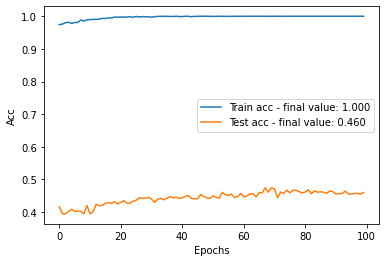

In [ ]:
acc = finetunig.history.history["acc"]; val_acc = finetunig.history.history["val_acc"]
plt.plot(acc, label="Train acc - final value: %.3f"%acc[-1])
plt.plot(val_acc, label="Test acc - final value: %.3f"%val_acc[-1])
plt.legend(); plt.xlabel("Epochs"); plt.ylabel("Acc"); plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


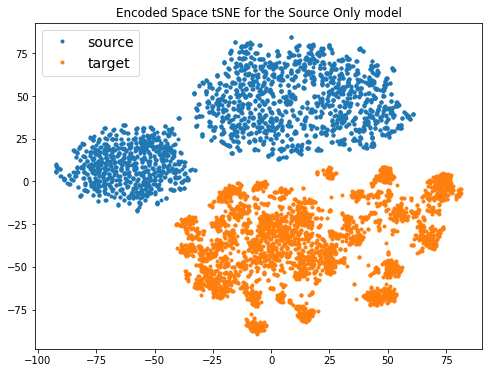

In [ ]:
LC25000_train_data_enc = finetunig.transform(LC25000_train_data_ex)
TCGA_train_data_enc = finetunig.transform(TCGA_train_data_ex)

np.random.seed(0)
X_ = np.concatenate((LC25000_train_data_enc, TCGA_train_data_enc))
X_tsne = TSNE(2).fit_transform(X_)
plt.figure(figsize=(8, 6))
plt.plot(X_tsne[:len(LC25000_train_data_ex), 0], X_tsne[:len(LC25000_train_data_ex), 1], '.', label="source")
plt.plot(X_tsne[len(LC25000_train_data_ex):, 0], X_tsne[len(LC25000_train_data_ex):, 1], '.', label="target")
plt.legend(fontsize=14)
plt.title("Encoded Space tSNE for the Source Only model")
plt.show()

In [ ]:
# convert the history.history dictionary to a pandas dataframe:     
hist_df = pd.DataFrame(finetunig.history.history) 

# or the describe() method:
hist_df.describe()

,loss,acc,val_loss,val_acc
count,100.000000,100.000000,100.000000,100.000000
mean,0.008828,0.997131,6.782726,0.443628
std,0.017919,0.005866,1.888183,0.019559
min,0.000003,0.974375,2.254078,0.394375
25%,0.000029,0.997734,5.802215,0.434297
50%,0.000807,0.999687,7.533870,0.446719
75%,0.007643,1.000000,8.430583,0.457500
max,0.080714,1.000000,8.742785,0.474375


In [ ]:
hist_df.to_csv("./Model/DANN_Model/MDD_256/MDD_source_Resnet_256_RMS_0.5e-5.csv")

# Fit with adaptation

### Run 1


In [ ]:
lr = 0.5e-5
momentum = 0.9
alpha = 0.0002


encoder = load_resnet50()
task = get_task()

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),  momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha), momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),  momentum=momentum)

In [ ]:
mdd = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=1,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd.fit(X=LC25000_train_data_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_train_data_ex, epochs=100, batch_size=8,  validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/100
400/400 [==============================] - 12s 23ms/step - loss: 0.4477 - acc: 0.8616 - disc_loss: 1.3637 - val_loss: 1.5700 - val_acc: 0.4709
Epoch 2/100
400/400 [==============================] - 8s 20ms/step - loss: 0.1214 - acc: 0.9544 - disc_loss: 0.9000 - val_loss: 1.7959 - val_acc: 0.4481
Epoch 3/100
400/400 [==============================] - 8s 21ms/step - loss: 0.0954 - acc: 0.9684 - disc_loss: 0.6046 - val_loss: 2.1007 - val_acc: 0.4419
Epoch 4/100
400/400 [==============================] - 8s 21ms/step - loss: 0.0856 - acc: 0.9737 - disc_loss: 0.4671 - val_loss: 2.2927 - val_acc: 0.4441
Epoch 5/100
400/400 [==============================] - 8s 21ms/step - loss: 0.0625 - acc: 0.9725 - disc_loss: 0.4033 - val_loss: 2.6021 - val_acc: 0.4512
Epoch 6/100
400/400 [==============================] - 8s 21ms/step - loss: 0.0609 - acc: 0.9759 - disc_loss: 0.3546 - val_loss: 2.9296 - val_acc: 0.4631
Epoch 7/100
400/400 [==============================] - 8s 20ms/step - loss:

### Run 2


In [ ]:
lr = 0.5e-5
momentum = 0.9
alpha = 0.0002


encoder = load_resnet50()
task = get_task()

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),  momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha), momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),  momentum=momentum)

In [ ]:
mdd = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=1,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd.fit(X=LC25000_train_data_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_train_data_ex, epochs=100, batch_size=8,  validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/100
400/400 [==============================] - 16s 23ms/step - loss: 0.4290 - acc: 0.8591 - disc_loss: 1.3716 - val_loss: 1.5569 - val_acc: 0.4741
Epoch 2/100
400/400 [==============================] - 9s 21ms/step - loss: 0.1072 - acc: 0.9600 - disc_loss: 0.8731 - val_loss: 1.9549 - val_acc: 0.4700
Epoch 3/100
400/400 [==============================] - 9s 21ms/step - loss: 0.0915 - acc: 0.9653 - disc_loss: 0.6133 - val_loss: 2.0418 - val_acc: 0.4572
Epoch 4/100
400/400 [==============================] - 9s 21ms/step - loss: 0.0722 - acc: 0.9734 - disc_loss: 0.4504 - val_loss: 2.2610 - val_acc: 0.4384
Epoch 5/100
400/400 [==============================] - 8s 21ms/step - loss: 0.0718 - acc: 0.9734 - disc_loss: 0.3569 - val_loss: 2.4944 - val_acc: 0.4678
Epoch 6/100
400/400 [==============================] - 8s 21ms/step - loss: 0.0591 - acc: 0.9797 - disc_loss: 0.3422 - val_loss: 2.9206 - val_acc: 0.4659
Epoch 7/100
400/400 [==============================] - 8s 21ms/step - loss:

### Run 3

In [ ]:
lr = 0.5e-5
momentum = 0.9
alpha = 0.0002


encoder = load_resnet50()
task = get_task()

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),  momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha), momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),  momentum=momentum)

In [ ]:
mdd = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=1,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd.fit(X=LC25000_train_data_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_train_data_ex, epochs=100, batch_size=8,  validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/100
400/400 [==============================] - 13s 23ms/step - loss: 0.4223 - acc: 0.8584 - disc_loss: 1.3733 - val_loss: 1.5307 - val_acc: 0.4437
Epoch 2/100
400/400 [==============================] - 9s 21ms/step - loss: 0.1139 - acc: 0.9581 - disc_loss: 0.8403 - val_loss: 1.8814 - val_acc: 0.4500
Epoch 3/100
400/400 [==============================] - 9s 21ms/step - loss: 0.1009 - acc: 0.9641 - disc_loss: 0.5475 - val_loss: 1.9552 - val_acc: 0.4450
Epoch 4/100
400/400 [==============================] - 8s 21ms/step - loss: 0.0860 - acc: 0.9681 - disc_loss: 0.4258 - val_loss: 1.9835 - val_acc: 0.4456
Epoch 5/100
400/400 [==============================] - 8s 21ms/step - loss: 0.0736 - acc: 0.9737 - disc_loss: 0.3585 - val_loss: 2.3242 - val_acc: 0.4466
Epoch 6/100
400/400 [==============================] - 8s 21ms/step - loss: 0.0666 - acc: 0.9753 - disc_loss: 0.2999 - val_loss: 2.5324 - val_acc: 0.4456
Epoch 7/100
400/400 [==============================] - 8s 21ms/step - loss:

### Run 4


In [ ]:
lr = 0.5e-5
momentum = 0.9
alpha = 0.0002


encoder = load_resnet50()
task = get_task()

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),  momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha), momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),  momentum=momentum)

In [ ]:
mdd = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=1,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd.fit(X=LC25000_train_data_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_train_data_ex, epochs=100, batch_size=8,  validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/100
400/400 [==============================] - 13s 23ms/step - loss: 0.4267 - acc: 0.8681 - disc_loss: 1.3802 - val_loss: 1.7187 - val_acc: 0.4706
Epoch 2/100
400/400 [==============================] - 8s 21ms/step - loss: 0.1117 - acc: 0.9628 - disc_loss: 0.9398 - val_loss: 1.9391 - val_acc: 0.4406
Epoch 3/100
400/400 [==============================] - 8s 21ms/step - loss: 0.0999 - acc: 0.9638 - disc_loss: 0.6461 - val_loss: 2.0393 - val_acc: 0.4412
Epoch 4/100
400/400 [==============================] - 8s 21ms/step - loss: 0.0795 - acc: 0.9694 - disc_loss: 0.5189 - val_loss: 2.2293 - val_acc: 0.4462
Epoch 5/100
400/400 [==============================] - 8s 21ms/step - loss: 0.0745 - acc: 0.9719 - disc_loss: 0.3904 - val_loss: 2.5772 - val_acc: 0.4669
Epoch 6/100
400/400 [==============================] - 8s 21ms/step - loss: 0.0586 - acc: 0.9800 - disc_loss: 0.3765 - val_loss: 2.7496 - val_acc: 0.4347
Epoch 7/100
400/400 [==============================] - 8s 21ms/step - loss:

### Run 5


In [ ]:
lr = 0.5e-5
momentum = 0.9
alpha = 0.0002


encoder = load_resnet50()
task = get_task()

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),  momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha), momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),  momentum=momentum)

In [ ]:
mdd = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=1,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd.fit(X=LC25000_train_data_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_train_data_ex, epochs=100, batch_size=8,  validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/100
400/400 [==============================] - 13s 24ms/step - loss: 0.4334 - acc: 0.8631 - disc_loss: 1.3827 - val_loss: 1.3798 - val_acc: 0.4409
Epoch 2/100
400/400 [==============================] - 9s 22ms/step - loss: 0.1057 - acc: 0.9625 - disc_loss: 0.8858 - val_loss: 1.7610 - val_acc: 0.4394
Epoch 3/100
400/400 [==============================] - 9s 21ms/step - loss: 0.0966 - acc: 0.9675 - disc_loss: 0.6064 - val_loss: 1.9398 - val_acc: 0.4359
Epoch 4/100
400/400 [==============================] - 9s 21ms/step - loss: 0.0829 - acc: 0.9691 - disc_loss: 0.4823 - val_loss: 2.2765 - val_acc: 0.4569
Epoch 5/100
400/400 [==============================] - 9s 21ms/step - loss: 0.0702 - acc: 0.9747 - disc_loss: 0.3966 - val_loss: 2.4473 - val_acc: 0.4525
Epoch 6/100
400/400 [==============================] - 9s 21ms/step - loss: 0.0711 - acc: 0.9762 - disc_loss: 0.3842 - val_loss: 2.6980 - val_acc: 0.4538
Epoch 7/100
400/400 [==============================] - 9s 21ms/step - loss:

### Result

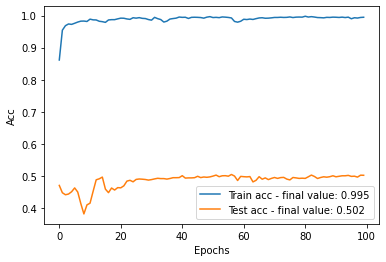

In [ ]:
acc = mdd.history.history["acc"]; val_acc = mdd.history.history["val_acc"]
plt.plot(acc, label="Train acc - final value: %.3f"%acc[-1])
plt.plot(val_acc, label="Test acc - final value: %.3f"%val_acc[-1])
plt.legend(); plt.xlabel("Epochs"); plt.ylabel("Acc"); plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


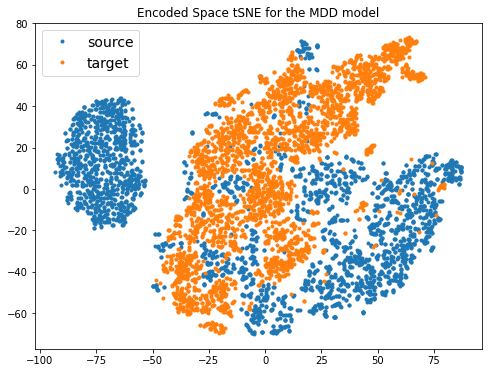

In [ ]:
LC25000_train_data_enc = mdd.transform(LC25000_train_data_ex)
TCGA_train_data_enc = mdd.transform(TCGA_train_data_ex)

np.random.seed(0)
X_ = np.concatenate((LC25000_train_data_enc, TCGA_train_data_enc))
X_tsne = TSNE(2).fit_transform(X_)
plt.figure(figsize=(8, 6))
plt.plot(X_tsne[:len(LC25000_train_data_ex), 0], X_tsne[:len(LC25000_train_data_ex), 1], '.', label="source")
plt.plot(X_tsne[len(LC25000_train_data_ex):, 0], X_tsne[len(LC25000_train_data_ex):, 1], '.', label="target")
plt.legend(fontsize=14)
plt.title("Encoded Space tSNE for the MDD model")
plt.show()

In [ ]:
# convert the history.history dictionary to a pandas dataframe:     
hist_df = pd.DataFrame(mdd.history.history) 

# or the describe() method:
hist_df.describe()

,loss,acc,disc_loss,val_loss,val_acc
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.036442,0.988609,1.284806,11.174327,0.485697
std,0.046896,0.014539,0.394580,4.246929,0.022369
min,0.009512,0.861562,0.210131,1.569989,0.382187
25%,0.018157,0.987500,1.168928,9.273279,0.487344
50%,0.024390,0.992344,1.391441,11.249821,0.494062
75%,0.040446,0.994375,1.540887,14.528313,0.498125
max,0.447664,0.997813,2.060994,18.673788,0.505000


In [ ]:
hist_df.to_csv("./Model/DANN_Model/MDD_256/MDD_Resnet_256_RMS_0.5e-5_g1_b8.csv")

In [ ]:
import gc
gc.collect()

1270